# Benchmarking the Recovery of Known Drug Targets from L1000 CRISPR KO Data: NR1I2 Version

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from math import log2
from maayanlab_bioinformatics.dge import characteristic_direction, limma_voom
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
from maayanlab_bioinformatics.enrichment.crisp import enrich_crisp
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
from os.path import exists
from scipy.stats import ttest_ind, ranksums
import h5py

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# Set KO gene
ko_gene = 'NR1I2'

# Set working directory
l1000_data_dir = '../L1000_data'

In [4]:
try: 
    expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index_col=0)
except: 
    l1000_data_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_data.tsv", sep='\t')

    l1000_data_list = []
    l1000_meta_list = []
    for row in l1000_data_df.itertuples(): 
        try:
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns:
            l1000_meta_list.append([col] + l1000_data_df.loc[row.Index].tolist())
        l1000_data_list.append(temp_df)
    expr_df = pd.concat(l1000_data_list, axis=1)

expr_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_U251MG.311_96H_X3_B35:F08,XPR010_U251MG.311_96H_X1_B35:F24,XPR010_U251MG.311_96H_X2_B35:F24,XPR010_U251MG.311_96H_X3_B35:F24,XPR010_YAPC.311_96H_X1_B35:F08,XPR010_YAPC.311_96H_X2_B35:F08,XPR010_YAPC.311_96H_X3_B35:F08,XPR010_YAPC.311_96H_X1_B35:F24,XPR010_YAPC.311_96H_X2_B35:F24,XPR010_YAPC.311_96H_X3_B35:F24
symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,6.158450,6.202200,6.285650,6.249500,6.071100,6.225575,6.03340,6.26310,6.29285,6.52600,...,6.41030,6.8449,6.698900,6.50580,6.553050,7.549575,6.84630,6.780425,6.951875,6.821550
PAX8,6.011775,6.106200,5.664900,5.665750,5.471950,5.780600,4.99225,5.30080,4.62410,4.82470,...,5.23020,4.5078,5.127000,5.00560,5.445525,5.153600,4.25930,5.035250,4.937550,4.004100
GUCA1A,4.835400,4.938175,4.842400,4.697725,4.872650,4.826450,5.21620,5.17145,4.99370,5.02665,...,4.89295,4.7672,4.806500,4.92165,5.290500,5.622600,5.89155,5.574350,5.208800,5.685100
EPHB3,6.632500,6.971400,6.574300,6.753650,6.427550,6.769800,8.29650,7.51050,7.67320,8.04430,...,8.03480,8.9509,7.990300,7.93880,7.675250,7.396850,6.47865,7.833150,7.967200,7.705101
ESRRA,7.819700,7.858900,8.497725,8.272900,8.056351,7.891300,8.73630,8.28170,8.84240,8.22250,...,7.25300,6.8591,7.123001,7.13630,8.613050,8.440750,7.94130,8.899151,8.561750,8.045325


In [5]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv"): 
    expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv' already exists!")

File at '../L1000_data/NR1I2_L1000_CRISPRKO_fulldata.tsv' already exists!


In [6]:
try: 
    meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index_col=0)
except:
    meta_df = pd.DataFrame(l1000_meta_list, columns=['id'] + l1000_data_df.columns.tolist()).set_index('id')
if 'batch' not in meta_df.columns:
    meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
XPR010_A375.311_96H_X1_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H


In [7]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv"): 
    meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv' already exists!")

File at '../L1000_data/NR1I2_L1000_CRISPRKO_metadata.tsv' already exists!


In [8]:
batches = meta_df['batch'].unique()
len(batches)

10

## Load in Control Data

In [9]:
ctrl_data_df = pd.read_csv(f"{l1000_data_dir}/L1000_Controls.tsv", sep='\t')
ctrl_data_df = ctrl_data_df[ctrl_data_df['batch'].isin(batches)]
set(batches).difference(ctrl_data_df['batch'])

set()

In [10]:
ctrl_data_df.head()

,local_id,persistent_id,batch
8910,L1000_LINCS_DCIC_2021_XPR010_A375.311_96H_A06_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR010_A375.311_96H
8911,L1000_LINCS_DCIC_2021_XPR010_A375.311_96H_D05_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR010_A375.311_96H
8912,L1000_LINCS_DCIC_2021_XPR010_A375.311_96H_D20_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR010_A375.311_96H
8913,L1000_LINCS_DCIC_2021_XPR010_A375.311_96H_D21_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR010_A375.311_96H
8914,L1000_LINCS_DCIC_2021_XPR010_A375.311_96H_E13_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR010_A375.311_96H


The following step extracts all control profiles from the same batch as the profiles of interest, and make take up to a few minutes to complete. 

In [11]:
try: 
    ctrl_expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index_col=0)
    ctrl_meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index_col=0)
except:
    ctrl_data_list = []
    ctrl_meta_list = []
    for row in ctrl_data_df.itertuples():
        try: 
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns: 
            ctrl_meta_list.append([col, row.batch])
        ctrl_data_list.append(temp_df)

    ctrl_expr_df = pd.concat(ctrl_data_list, axis=1)
    ctrl_meta_df = pd.DataFrame(ctrl_meta_list, columns=['id', 'batch']).set_index('id')

In [12]:
ctrl_expr_df.head()

,XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H_X3_B35:D05,XPR010_A375.311_96H_X1_B35:D20,XPR010_A375.311_96H_X2_B35:D20,XPR010_A375.311_96H_X3_B35:D20,XPR010_A375.311_96H_X1_B35:D21,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,7.260575,7.280875,7.02010,6.966801,7.45305,7.79865,7.34975,7.165100,7.708175,7.48150,...,12.6010,8.773951,8.02120,12.157150,7.691299,7.311550,12.085751,8.362350,9.20055,11.97370
ADA,5.064700,5.259250,5.22435,5.144300,5.38295,5.03075,5.07075,5.199075,4.932025,5.28315,...,4.6644,4.806450,4.66950,3.391350,5.972750,5.615875,4.137550,6.133075,4.75340,4.23540
CDH2,5.706775,5.822050,5.69430,5.853000,5.64155,5.71160,5.98715,5.800150,5.671200,5.80255,...,6.0781,5.741250,5.86595,5.915725,5.294300,6.179800,6.161100,5.736300,5.83550,5.75765
AKT3,0.896850,2.521300,2.37685,1.295950,3.11635,2.51195,2.38330,1.790250,1.295950,3.40630,...,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
MED6,5.884050,5.757250,5.77825,5.589350,6.05750,5.44470,5.63980,5.929700,5.832875,5.86350,...,6.2660,5.605700,6.17515,5.849500,5.851400,6.168350,5.662300,5.871375,6.37535,6.18240


In [13]:
ctrl_meta_df.head()

,batch
id,
XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H


In [14]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv"): 
    ctrl_expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv' already exists!")

File at '../L1000_data/NR1I2_L1000_Controls_fulldata.tsv' already exists!


In [15]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv"): 
    ctrl_meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv' already exists!")

File at '../L1000_data/NR1I2_L1000_Controls_metadata.tsv' already exists!


## Process Data

### Combine data and remove duplicate genes

In [16]:
combined_expr_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_expr_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,4.45315,4.23635,4.634250,3.93165,3.87275,3.75120,5.3409,4.67510,5.60880,5.23860,...,10.192900,10.741025,10.62880,10.17440,11.360250,10.609800,10.58320,11.2271,11.164000,10.640949
A2M,7.22560,7.47065,8.596849,7.24335,7.29490,7.76080,8.1608,5.55060,8.57160,5.88430,...,8.146475,7.649900,8.25165,8.60140,7.470325,7.525375,7.99345,7.0502,8.668000,8.725750
A4GALT,5.43295,5.44650,5.665200,5.29545,5.68145,5.51620,6.7321,6.05495,6.72805,5.74780,...,5.415850,6.452750,5.52640,5.43765,5.709750,6.054850,4.93555,6.1569,6.114300,4.902300
A4GNT,5.37260,5.28950,5.293250,5.18680,5.30390,5.38095,5.2655,5.52010,5.44740,5.62385,...,8.344800,8.872550,8.37400,8.79715,8.576900,8.662701,8.30970,8.8629,8.714951,8.285049
AAAS,7.51980,7.64780,7.956600,7.59620,8.07660,7.87480,8.1372,7.55920,8.28530,7.90890,...,6.719550,6.666550,6.71455,6.97565,6.509600,6.576250,6.78680,6.4280,6.527250,6.776250


## Compute Signatures: Batch Perturbations vs. Batch Controls

In [17]:
batch_profiles = {x: {'perts': [], 'ctrls': []} for x in batches}
for b in batches: 
    batch_profiles[b]['perts'] = meta_df[meta_df['batch'] == b].index.tolist()
    batch_profiles[b]['ctrls'] = ctrl_meta_df[ctrl_meta_df['batch'] == b].index.tolist()

In [18]:
batch_signatures = {
  'cd': {}, 
  'limma': {}, 
  'limma-voom': {},
  'fc': {},
  'ranksum': {},
  'ttest': {}
}

### Characteristic Direction

In [19]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset):
  
    signature = characteristic_direction(
        dataset.loc[:, ctrl_ids], 
        dataset.loc[:, case_ids], 
        calculate_sig=True
    )
    signature['Significance'] = signature['CD-coefficient'].apply(abs)
    
    return signature.sort_values(by=['CD-coefficient'], ascending=False)

Note: the following step may take a few minutes to run.

In [20]:
for b in batches: 
    batch_signatures['cd'][b] = cd_signature(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

### Limma

In [21]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, voom):
    
    signature = limma_voom.limma_voom_differential_expression(
        dataset.loc[:, ctrl_ids],
        dataset.loc[:, case_ids],
        voom_design=voom,
        filter_genes=False
    )
    signature['Significance'] = signature['P.Value']

    return signature.sort_values("t", ascending=False)

Note: the following step may take a few minutes to run.

In [22]:
for b in batches: 
    batch_signatures['limma'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=False
    )

R[write to console]: Loading required package: R.oo

R[write to console]: Loading required package: R.methodsS3

R[write to console]: R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R[write to console]: R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

R[write to console]: 
Attaching package: ‘R.oo’


R[write to console]: The following object is masked from ‘package:R.methodsS3’:

    throw


R[write to console]: The following objects are masked from ‘package:methods’:

    getClasses, getMethods


R[write to console]: The following objects are masked from ‘package:base’:

    attach, detach, load, save


R[write to console]: R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.

R[write to console]: 
Attaching package: ‘R.utils’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: The following objects are masked from

In [23]:
for b in batches: 
    batch_signatures['limma-voom'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df,
        voom=True
    )

### Wilcoxon Rank-Sum Test

In [24]:
def ranksum(ctrl_ids, case_ids, dataset):
  if len(ctrl_ids) + len(case_ids) < 32: 
    print("Warning! Sample sizes < 16 generally do not provide good results. ")
  res_array = []
  for gene in dataset.index: 
    res = ranksums(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids]
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [25]:
for b in batches: 
    batch_signatures['ranksum'][b] = ranksum(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

Warning! Sample sizes < 16 generally do not provide good results. 
Warning! Sample sizes < 16 generally do not provide good results. 
Warning! Sample sizes < 16 generally do not provide good results. 


### Welch's t-test

In [26]:
def ttest(ctrl_ids, case_ids, dataset):
  res_array = []
  for gene in dataset.index: 
    res = ttest_ind(
      dataset.loc[gene, case_ids],
      dataset.loc[gene, ctrl_ids],
      equal_var = False
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  return signature.sort_values(by=['Statistic'], ascending=False)

In [27]:
for b in batches: 
    batch_signatures['ttest'][b] = ttest(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        combined_expr_df
    )

### (log2) Fold Change

In [28]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset):

    case_mean = dataset.loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset.loc[:, ctrl_ids].mean(axis=1)

    signature = case_mean / (ctrl_mean + 0.001)

    signature_df = pd.DataFrame(
        signature.apply(lambda x: log2(x+0.001)), columns=['logFC']
    )
    signature_df['Significance'] = signature_df['logFC'].apply(abs)
    
    return signature_df.sort_values('logFC', ascending=False)

In [29]:
for b in batches: 
    batch_signatures['fc'][b] = logFC(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        combined_expr_df
    )

## All signatures

In [30]:
all_signatures = {}

all_signatures['cd_all']= pd.concat([
    df['CD-coefficient'].rename(b) for (b, df) in batch_signatures['cd'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['limma-voom_all'] = pd.concat([
    df['t'].rename(b) for (b, df) in batch_signatures['limma-voom'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ranksum_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ranksum'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['ttest_all'] = pd.concat([
    df['Statistic'].rename(b) for (b, df) in batch_signatures['ttest'].items()
], axis=1).sort_index().rename_axis('Gene')
all_signatures['fc_all'] = pd.concat([
    df['logFC'].rename(b) for (b, df) in batch_signatures['fc'].items()
], axis=1).sort_index().rename_axis('Gene')

for k in all_signatures.keys(): 
    method = k.split('_')[0].upper()
    display(Markdown(f"All {method} batch signatures"))
    display(all_signatures[k])

All CD batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-0.019577,-0.016974,-0.015616,-0.016290,-0.020444,-0.018519,-0.017728,-0.020971,-0.017763,-0.019295
A2M,0.003215,-0.003538,0.001771,-0.001684,-0.001222,-0.002409,0.001087,0.002743,0.001958,0.004480
A4GALT,-0.000740,0.000667,0.000689,0.002151,0.000054,-0.001610,-0.000614,0.000041,-0.000140,0.000447
A4GNT,-0.011040,-0.008234,-0.014184,-0.013903,-0.014138,-0.015587,-0.013585,-0.012055,-0.013713,-0.009598
AAAS,0.004927,0.005585,0.005249,0.003679,0.005078,0.004642,0.005265,0.004076,0.004921,0.003304
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.000307,-0.001142,-0.000563,-0.000166,-0.001886,-0.001636,-0.000132,-0.000568,-0.001656,0.000642
ZXDC,-0.004677,-0.009372,-0.007265,-0.002839,-0.005829,-0.001725,-0.007841,-0.008623,-0.010583,-0.009344
ZYX,0.018972,0.014685,0.018484,0.012741,0.019393,0.011563,0.008750,0.022170,0.016844,0.015572


All LIMMA batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-60.019539,-28.815911,-44.964117,-42.496500,-76.125622,-40.349357,-38.287313,-65.604340,-55.876038,-43.141008
A2M,4.845533,-1.847583,3.406957,-2.852660,-2.416547,-0.537058,1.565255,9.006032,3.824993,2.729793
A4GALT,-3.617646,-1.016386,0.559526,6.139557,-2.310624,-4.533725,-3.529359,0.950890,-2.583732,2.579730
A4GNT,-42.919025,-19.718965,-50.182363,-30.878052,-47.377980,-36.774901,-24.278347,-24.678781,-38.743252,-27.158267
AAAS,26.282910,13.767572,18.236763,14.897501,24.929960,13.017880,16.846031,16.416623,23.690760,14.218616
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.235291,-2.809396,-0.987368,1.787694,-6.089417,-4.552719,-0.102972,-0.915882,-4.805944,-6.810436
ZXDC,-16.760846,-11.868575,-15.712726,-6.614901,-12.108318,-1.424355,-16.841576,-23.859809,-22.600620,-8.387029
ZYX,36.112290,13.855560,23.705964,20.629454,37.057409,15.960206,11.385518,35.864251,30.875875,25.291581


All LIMMA-VOOM batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-50.651436,-24.147615,-33.979375,-32.001838,-42.683320,-35.396960,-27.405920,-32.899780,-39.820453,-32.782214
A2M,4.955400,-1.844724,3.600092,-2.898473,-2.402441,-0.538432,1.565448,9.340704,3.912297,2.731678
A4GALT,-3.589970,-1.011528,0.554346,6.084361,-2.312838,-4.518897,-3.514023,0.952444,-2.629774,2.562922
A4GNT,-39.256483,-17.359412,-45.350198,-25.820052,-40.333346,-29.798909,-21.557148,-22.496492,-34.648513,-26.759321
AAAS,26.203469,13.839074,18.304133,14.374574,24.737275,13.112901,16.680130,16.330677,22.507931,14.093464
...,...,...,...,...,...,...,...,...,...,...
ZXDB,0.230335,-2.691749,-0.959721,1.785147,-6.041614,-4.333230,-0.102150,-0.908215,-4.765242,-6.808437
ZXDC,-16.024135,-10.927358,-14.756960,-6.754619,-11.315591,-1.416653,-15.285268,-22.543888,-22.328144,-8.161337
ZYX,44.932672,19.309508,31.522980,25.008262,49.472130,19.131338,13.658334,46.537964,35.157099,30.122082


All RANKSUM batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-3.765875,-3.064524,-3.75,-3.780756,-3.478042,-3.780756,-3.765875,-3.780756,-3.780756,-3.780756
A2M,3.476193,-0.425628,2.60,-2.170434,-1.919879,-0.093352,0.772487,3.687404,2.847236,1.166900
A4GALT,-3.041669,-0.851257,-0.15,3.780756,-2.532014,-3.313996,-3.089949,0.933520,-2.473828,2.287124
A4GNT,-3.765875,-3.064524,-3.75,-3.780756,-3.478042,-3.780756,-3.765875,-3.780756,-3.780756,-3.780756
AAAS,3.765875,3.064524,3.75,3.780756,3.478042,3.780756,3.765875,3.780756,3.780756,3.780756
...,...,...,...,...,...,...,...,...,...,...
ZXDB,-0.289683,-2.724021,-1.20,1.400280,-3.478042,-3.267320,-0.241402,-1.586984,-3.780756,-3.780756
ZXDC,-3.765875,-3.064524,-3.75,-3.734080,-3.478042,-1.633660,-3.765875,-3.780756,-3.780756,-3.687404
ZYX,3.765875,3.064524,3.75,3.780756,3.478042,3.780756,3.765875,3.780756,3.780756,3.780756


All TTEST batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-47.343241,-25.717956,-42.861009,-34.360667,-60.751893,-30.899225,-35.139583,-71.404329,-71.268026,-42.707136
A2M,3.446543,-0.814405,2.952941,-1.898905,-1.956064,-0.406014,0.900629,6.119073,2.353210,1.439096
A4GALT,-4.378029,-0.793152,0.384555,9.602556,-4.454827,-7.037581,-4.154804,0.991804,-3.476283,4.040070
A4GNT,-64.783790,-29.296212,-51.959749,-45.564620,-65.113722,-51.629066,-35.261361,-38.811093,-59.815876,-36.346808
AAAS,17.724526,12.042168,29.167603,12.077002,20.545805,14.861539,12.542705,16.359871,30.748987,17.028256
...,...,...,...,...,...,...,...,...,...,...
ZXDB,-0.416080,-4.099616,-1.601354,1.897163,-8.683223,-4.247329,-0.495350,-1.496384,-6.292793,-6.538260
ZXDC,-21.116532,-16.305855,-23.107084,-10.698635,-22.546653,-2.146681,-18.682881,-33.469199,-23.994271,-12.848385
ZYX,39.004683,19.249983,26.097359,22.588704,52.219297,27.154695,11.963219,47.136471,21.371093,23.821547


All FC batch signatures

,XPR010_A375.311_96H,XPR010_A549.311_96H,XPR010_AGS.311_96H,XPR010_BICR6.311_96H,XPR010_ES2.311_96H,XPR010_HT29.311_96H,XPR010_MCF7.311_96H,XPR010_PC3.311B_96H,XPR010_U251MG.311_96H,XPR010_YAPC.311_96H
Gene,,,,,,,,,,
A1CF,-1.418462,-1.040406,-1.136366,-1.194335,-1.601811,-1.222860,-1.217650,-1.387168,-1.239583,-1.206195
A2M,0.157055,-0.123350,0.240677,-0.164841,-0.072379,-0.026877,0.108772,0.272403,0.159051,0.225687
A4GALT,-0.076488,-0.044904,0.009053,0.139620,-0.056478,-0.118418,-0.108546,0.019782,-0.071314,0.106599
A4GNT,-0.767852,-0.735214,-0.931993,-0.863029,-0.898443,-0.979517,-0.801284,-0.709464,-0.933154,-0.581013
AAAS,0.345446,0.417120,0.329362,0.214201,0.396100,0.323869,0.314384,0.238665,0.325797,0.263725
...,...,...,...,...,...,...,...,...,...,...
ZXDB,-0.003182,-0.080916,-0.024353,0.027470,-0.115208,-0.109797,-0.006245,-0.023256,-0.091842,-0.145286
ZXDC,-0.340808,-0.592351,-0.441383,-0.242187,-0.334438,-0.054448,-0.550889,-0.568556,-0.568459,-0.348030
ZYX,1.162756,0.813515,1.213884,0.732871,1.197700,0.854481,0.506134,1.124026,1.042041,1.012969


## Enrichment Analysis Rankings

In [31]:
# Function to get Enrichr Results
def getEnrichrLibrary(library_name): 
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={library_name}'
    resp = requests.get(ENRICHR_URL)
    if not resp.ok: 
        raise Exception(f"Error downloading {library_name} library from Enrichr, please try again.")
    return resp.json()[library_name]['terms']

def getLibraryIter(libdict):
    for k,v in libdict.items():
        if type(v) == list:
            yield k, v
        else:
            yield k, list(v.keys())

def enrich(gene_list, lib_json, name): 
    all_terms = list(lib_json.keys())
    termranks = []
    enrich_res = enrich_crisp(gene_list, getLibraryIter(lib_json), 20000, False)
    enrich_res = [[r[0], r[1].pvalue] for r in enrich_res]
    sorted_res = sorted(enrich_res, key=lambda x: x[1])
    for i in range(len(sorted_res)): 
        termranks.append([name, sorted_res[i][0], i])
    for t in set(all_terms).difference([x[1] for x in termranks]): 
        i+=1
        termranks.append([name, t, i])
    return pd.DataFrame(termranks, columns=['Gene_Set', 'Term', 'Rank'])

In [32]:
chea2022 = getEnrichrLibrary('ChEA_2022')

In [33]:
# Get gene lists to put into Enrichr
gene_lists = {}
for m in all_signatures.keys():
    mname = m.split('_')[0]
    gene_lists[mname] = {'up': {}, 'down': {}, 'combined': {}}
    for col in all_signatures[m].columns: 
        gene_lists[mname]['up'][col] = all_signatures[m][col].sort_values(ascending=False).index.tolist()[:100]
        gene_lists[mname]['down'][col] = all_signatures[m][col].sort_values(ascending=True).index.tolist()[:100]
        gene_lists[mname]['combined'][col] = gene_lists[mname]['up'][col] + gene_lists[mname]['down'][col]

In [34]:
# Get results
chea2022_results = []

for m in gene_lists.keys(): 
    for sig in gene_lists[m]['up'].keys(): 
        chea2022_results.append(enrich(gene_lists[m]['up'][sig], chea2022, f"{sig}:{m}:up:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['down'][sig], chea2022, f"{sig}:{m}:down:ChEA 2022"))
        chea2022_results.append(enrich(gene_lists[m]['combined'][sig], chea2022, f"{sig}:{m}:combined:ChEA 2022"))

chea2022_df = pd.concat(chea2022_results, axis=0)

In [35]:
dex_chea2022_df = chea2022_df[chea2022_df['Term'].apply(lambda term: 'NR1I2' in term)]
dex_chea2022_df['Library'] = 'ChEA 2022'

In [36]:
def createResultsDf(df):
  df['Method'] = df['Gene_Set'].apply(lambda x: x.split(':')[1])
  df['Direction'] = df['Gene_Set'].apply(lambda x: x.split(':')[2])
  df['Method_Direction'] = df.apply(lambda row: row.Method + ':' + row.Direction, axis=1)
  df['TF'] = df['Term'].apply(lambda x: x.split(' ')[0].split('_')[0])
  df['Cell'] = df['Gene_Set'].apply(lambda x: x.split(':')[0].split('_')[1])
  df['Batch'] = df['Gene_Set'].apply(lambda x: x.split(':')[0])

In [37]:
createResultsDf(dex_chea2022_df)

In [38]:
full_df = dex_chea2022_df

up_df = full_df[full_df['Direction'] == 'up']
down_df = full_df[full_df['Direction'] == 'down']
combined_df = full_df[full_df['Direction'] == 'combined']

In [39]:
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']))
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']))
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']))

Mean rank of NR1I2 terms from ChEA 2022 for up genes from each method.

,Rank
Method,
ranksum,388.5
fc,426.0
limma,562.1
ttest,587.3
limma-voom,600.1
cd,663.9


Mean rank of NR1I2 terms from ChEA 2022 for down genes from each method.

,Rank
Method,
limma-voom,37.3
cd,52.8
limma,58.5
ttest,128.1
fc,326.9
ranksum,415.8


Mean rank of NR1I2 terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
limma-voom,271.2
limma,280.7
cd,332.3
fc,379.5
ttest,404.0
ranksum,420.1


## Random results

In [40]:
# bootstrap random results
random_arr_chea2022 = []
for i in range(10):
    rand_100 = sample(combined_expr_df.index.tolist(), 100)
    rand_200 = sample(combined_expr_df.index.tolist(), 200)

    random_arr_chea2022.append(enrich(rand_100, chea2022, 'random:100'))
    random_arr_chea2022.append(enrich(rand_200, chea2022, 'random:200'))

rand_chea2022_df = pd.concat(random_arr_chea2022, axis=0)
rand_chea2022_df['Library'] = 'ChEA 2022'
rand_chea2022_df['TF'] = rand_chea2022_df['Term'].apply(lambda x: x.split(' ')[0])

rand_df = rand_chea2022_df
rand_df = rand_df[rand_df['TF'].isin(['NR0B1'])]
rand_df['Method'] = 'random'

## Boxplots

In [41]:
full_df['Cell'] = full_df['Cell'].apply(lambda x: x.replace('.311', ''))

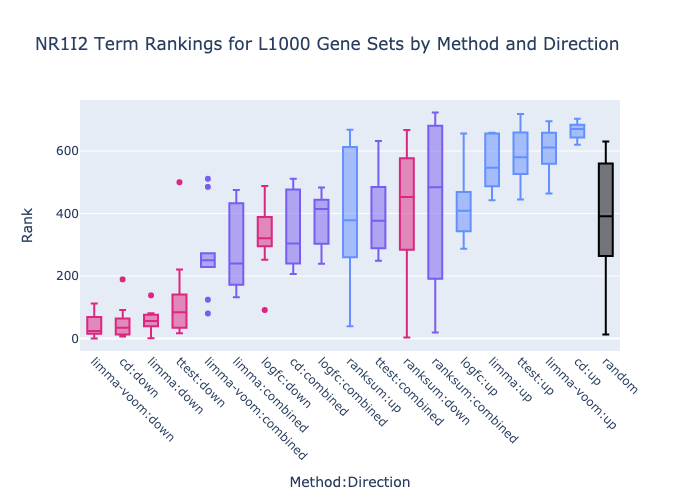

In [42]:
color_dict = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.replace('fc', 'logfc'),
            marker_color=color_dict[gs.split(':')[1]]
        )
    )
fig1.add_trace(
    go.Box(
        y=rand_df[rand_df['Method']==f'random']['Rank'].tolist(),
        name='random',
        marker_color='black'
    )
)
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

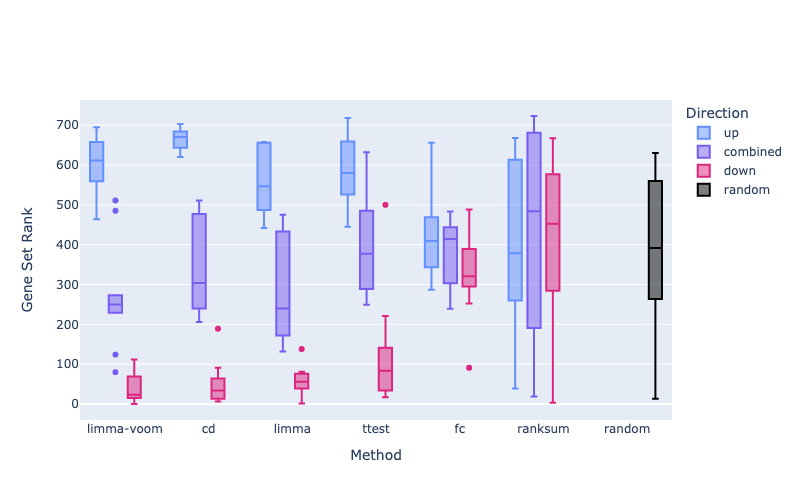

In [43]:
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
fig1 = go.Figure()
order = full_df.groupby(['Method_Direction']).mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
full_df['Method'] = pd.Categorical(full_df['Method'], order)
full_df = full_df.sort_values(by=['Method'])

for d in ['up', 'combined', 'down']:
  d_df = full_df[full_df['Direction'] == d]
  fig1.add_trace(
    go.Box(
      x=d_df['Method'],
      y=d_df['Rank'],
      name=d, 
      marker_color=method_color_map[d]
    )
  )

fig1.add_trace(
  go.Box(
    x=rand_df['Method'],
    y=rand_df['Rank'],
    name='random',
    marker_color='black'
  )
)

fig1.update_layout(
  width=800,
  boxmode='group',
  boxgap=0.1,
  xaxis={
    'title': {'text': 'Method'},
  },
  yaxis={
    'title': {'text': 'Gene Set Rank'}
  },
  legend_title_text="Direction"
)
fig1.show("png")
fig1.write_image(f'/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/4_{ko_gene}_1_300dpi.png', scale=(800/300))

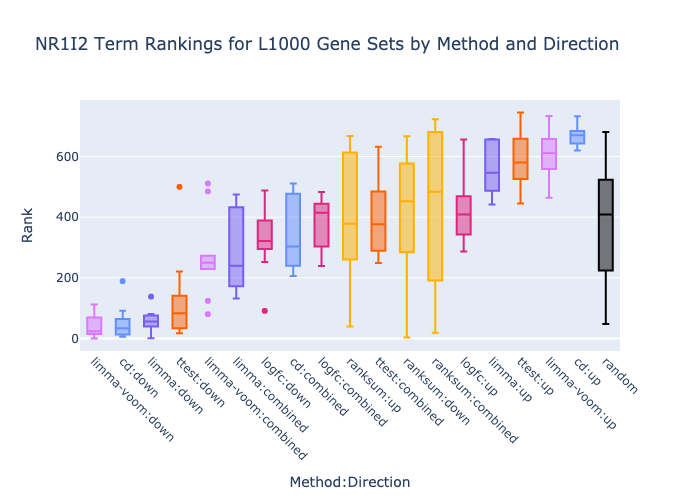

In [119]:
color_dict = {
    'cd': '#648FFF',
    'limma': '#785EF0', 
    'limma-voom': '#DA79FF',
    'fc': '#DC267F',
    'ttest': '#FE6100',
    'ranksum': '#FFB000'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.replace('fc', 'logfc'),
            marker_color=color_dict[gs.split(':')[0]]
        )
    )
fig1.add_trace(
    go.Box(
        y=rand_df[rand_df['Method']==f'random']['Rank'].tolist(),
        name='random',
        marker_color='black'
    )
)
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

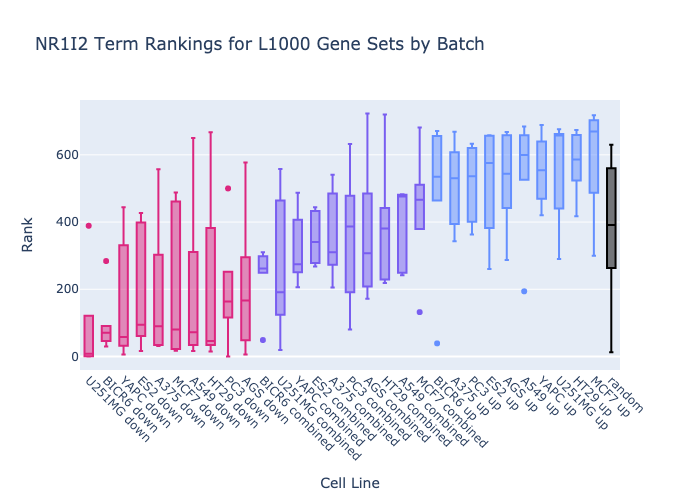

In [44]:
color_dict = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}

box_count = 0
full_df['Batch'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
fig1 = go.Figure()
dir_batch_df = full_df.set_index(['Direction', 'Batch'])
for (d, b) in dir_batch_df.groupby(['Direction', 'Batch']).mean(numeric_only=True).sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=dir_batch_df.loc[(d,b)]['Rank'].tolist(),
            name=b.split('_')[1].split('.')[0] + ' ' + d,
            marker_color=color_dict[d]
        )
    )
fig1.add_trace(
    go.Box(
        y=rand_df[rand_df['Method']==f'random']['Rank'].tolist(),
        name='random',
        marker_color='black'
    )
)
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Batch",
    xaxis={
        'title': {'text': 'Cell Line'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.update_xaxes(tickangle=45)
fig1.show("png")

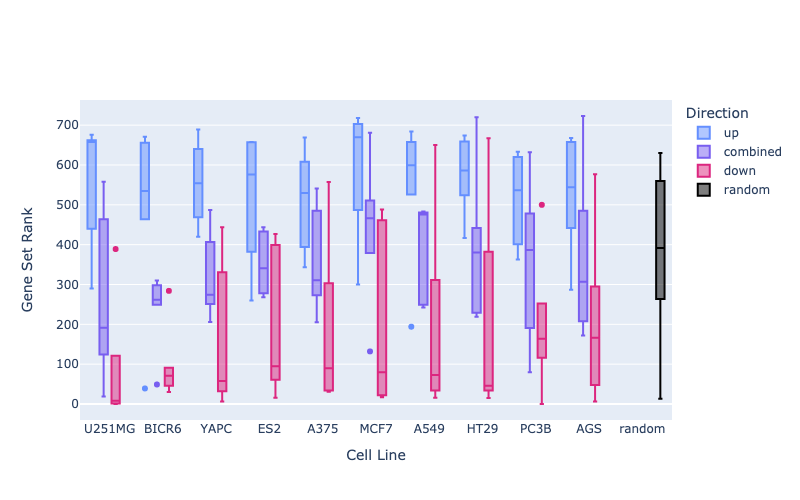

In [45]:
method_color_map = {
    'up': '#648FFF',
    'down': '#DC267F', 
    'combined': '#785EF0'
}
fig1 = go.Figure()
order = full_df.groupby(['Direction', 'Cell']).mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x[1].split(':')[0]).unique()
full_df['Cell'] = pd.Categorical(full_df['Cell'], order)
full_df = full_df.sort_values(by=['Cell'])

for d in ['up', 'combined', 'down']:
  d_df = full_df[full_df['Direction'] == d]
  fig1.add_trace(
    go.Box(
      x=d_df['Cell'],
      y=d_df['Rank'],
      name=d, 
      marker_color=method_color_map[d]
    )
  )

fig1.add_trace(
  go.Box(
    x=rand_df['Method'],
    y=rand_df['Rank'],
    name='random',
    marker_color='black'
  )
)

fig1.update_layout(
  width=800,
  boxmode='group',
  boxgap=0.1,
  xaxis={
    'title': {'text': 'Cell Line'},
  },
  yaxis={
    'title': {'text': 'Gene Set Rank'}
  },
  legend_title_text="Direction"
)
fig1.show("png")
fig1.write_image(f'/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/4_{ko_gene}_2_300dpi.png', scale=(800/300))